In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import os

japanize_matplotlib.japanize() 

In [49]:
e_data = pd.read_csv('./data/maikin/e.csv', encoding='utf_8_sig', low_memory=False)
e_data.head()

,年,月,産業分類,規模,就業形態,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,E,0,0,22630,18319.0,NaN,NaN,4311.0,207.0,182.0,25.0,24.2,NaN,NaN,NaN,NaN,NaN
1,1960,CY,E,4,0,28690,22409.0,NaN,NaN,NaN,200.3,173.8,26.5,24.2,NaN,NaN,NaN,NaN,NaN
2,1960,CY,E,5,0,20293,16501.0,NaN,NaN,NaN,207.9,184.9,23.0,24.1,NaN,NaN,NaN,NaN,NaN
3,1960,CY,E,7,0,16897,14742.0,NaN,NaN,NaN,215.3,190.2,25.1,24.3,NaN,NaN,NaN,NaN,NaN
4,1960,CY,E12,0,0,15370,13448.0,NaN,NaN,1922.0,208.5,186.6,21.9,23.9,NaN,NaN,NaN,NaN,NaN


In [50]:
all_data = pd.read_csv('./data/maikin/all_cleaned.csv', encoding='utf_8_sig', low_memory=False)
all_data.head()

,年,月,産業分類,規模,就業形態,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,0,26250,22547.0,NaN,NaN,3703.0,193.6,170.8,22.8,23.0,NaN,NaN,NaN,NaN,NaN
1,1960,CY,C,4,0,28786,24682.0,NaN,NaN,NaN,193.2,168.4,24.8,22.8,NaN,NaN,NaN,NaN,NaN
2,1960,CY,C,5,0,22422,19121.0,NaN,NaN,NaN,196.7,175.1,21.6,23.5,NaN,NaN,NaN,NaN,NaN
3,1960,CY,C,7,0,18826,16814.0,NaN,NaN,NaN,187.9,176.3,11.6,23.4,NaN,NaN,NaN,NaN,NaN
4,1960,CY,D,0,0,21213,17952.0,NaN,NaN,3261.0,211.0,186.4,24.6,24.1,NaN,NaN,NaN,NaN,NaN


## 前処理

In [51]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
all_data["産業分類"] = all_data["産業分類"].str.slice(0,1)
all_data["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [52]:
# 月 = CY のみのデータを抽出
all_data = all_data[all_data["月"] == "CY"]

# 数値列を数値型に変換
all_data["現金給与総額"] = pd.to_numeric(all_data["現金給与総額"], errors='coerce')
all_data["規模"] = pd.to_numeric(all_data["規模"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
all_data = all_data.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
all_data.head()

,年,月,産業分類,就業形態,規模,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,4.0,24071.00,20791.00,NaN,NaN,3703.0,192.8500,172.6500,20.200,23.175,NaN,NaN,NaN,NaN,NaN
1,1960,CY,D,0,4.0,21433.25,18094.25,NaN,NaN,3261.0,211.3000,186.2000,25.100,24.050,NaN,NaN,NaN,NaN,NaN
2,1960,CY,E,0,4.0,22637.30,18694.90,NaN,NaN,4106.8,210.5675,182.1225,28.445,24.145,NaN,NaN,NaN,NaN,NaN
3,1960,CY,F,0,4.0,36734.00,27890.25,NaN,NaN,8669.0,183.1750,168.4250,14.750,23.950,NaN,NaN,NaN,NaN,NaN
4,1961,CY,C,0,4.0,26290.75,22150.75,NaN,NaN,4716.0,191.9000,170.6250,21.275,22.850,NaN,NaN,NaN,NaN,NaN


In [53]:
# 就業形態が0（全形態）のみを抽出
all_data = all_data[all_data["就業形態"] == 0]

# 産業分類T（調査産業計）のデータは除く
all_data = all_data[all_data["産業分類"] != "T"]

# 不要な列をドロップ
all_data = all_data.drop(columns=["月","規模","就業形態"])

all_data.head()

,年,産業分類,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,C,24071.00,20791.00,NaN,NaN,3703.0,192.8500,172.6500,20.200,23.175,NaN,NaN,NaN,NaN,NaN
1,1960,D,21433.25,18094.25,NaN,NaN,3261.0,211.3000,186.2000,25.100,24.050,NaN,NaN,NaN,NaN,NaN
2,1960,E,22637.30,18694.90,NaN,NaN,4106.8,210.5675,182.1225,28.445,24.145,NaN,NaN,NaN,NaN,NaN
3,1960,F,36734.00,27890.25,NaN,NaN,8669.0,183.1750,168.4250,14.750,23.950,NaN,NaN,NaN,NaN,NaN
4,1961,C,26290.75,22150.75,NaN,NaN,4716.0,191.9000,170.6250,21.275,22.850,NaN,NaN,NaN,NaN,NaN


## EDA

### 製造業の対他産業賃金比

#### 全規模

In [16]:
all_wages = all_data[["年","月","産業分類", "規模", "就業形態", "現金給与総額"]]
all_wages.head()

,年,月,産業分類,規模,就業形態,現金給与総額
0,1960,CY,C,0,0,26250
1,1960,CY,C,4,0,28786
2,1960,CY,C,5,0,22422
3,1960,CY,C,7,0,18826
4,1960,CY,D,0,0,21213


In [17]:
# 月 = CY のみのデータを抽出
all_wages = all_wages[all_wages["月"] == "CY"]

In [18]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
all_wages["産業分類"] = all_wages["産業分類"].str.slice(0,1)
all_wages["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [19]:
# 数値列を数値型に変換
all_wages["現金給与総額"] = pd.to_numeric(all_wages["現金給与総額"], errors='coerce')
all_wages["規模"] = pd.to_numeric(all_wages["規模"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
all_wages = all_wages.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
all_wages.head()

,年,月,産業分類,就業形態,規模,現金給与総額
0,1960,CY,C,0,4.0,24071.00
1,1960,CY,D,0,4.0,21433.25
2,1960,CY,E,0,4.0,22637.30
3,1960,CY,F,0,4.0,36734.00
4,1961,CY,C,0,4.0,26290.75


In [20]:
# 就業形態が0（全形態）のみを抽出
all_wages = all_wages[all_wages["就業形態"] == 0]

# 不要な列をドロップ
all_wages = all_wages.drop(columns=["月","規模","就業形態"])

In [21]:
# その年の製造業に対する賃金比率を計算、小数点第3位まで
all_wages["製造業賃金比率"] = all_wages.apply(lambda row: round(row["現金給与総額"] / all_wages[(all_wages["年"] == row["年"]) & (all_wages["産業分類"] == "E")]["現金給与総額"].values[0], 3), axis=1)
all_wages.head()

,年,産業分類,現金給与総額,製造業賃金比率
0,1960,C,24071.00,1.063
1,1960,D,21433.25,0.947
2,1960,E,22637.30,1.000
3,1960,F,36734.00,1.623
4,1961,C,26290.75,1.059


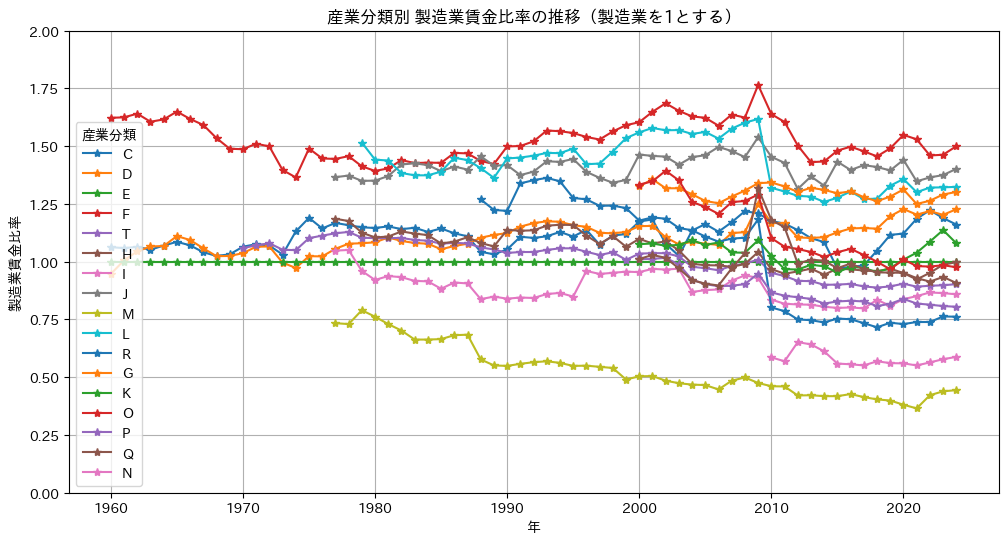

In [22]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_wages["産業分類"].unique():
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

- 以下の区別に分類する
    - 常に下回るもの
    - 交差するもの
    - 常に上回るもの

In [23]:
# 各産業分類を製造業賃金比率の値によって分類
cat_lower = []
cat_upper = []
cat_cross = []

for industry in all_wages["産業分類"].unique():
    industry_data = all_wages[all_wages["産業分類"] == industry]
    ratios = industry_data["製造業賃金比率"].values
    
    # すべての値が1.0より大きい
    if all(ratio > 1.0 for ratio in ratios):
        cat_upper.append(industry)
    # すべての値が1.0より小さい
    elif all(ratio < 1.0 for ratio in ratios):
        cat_lower.append(industry)
    # それ以外（交差する）
    else:
        cat_cross.append(industry)

print("常に上回る産業:", cat_upper)
print("常に下回る産業:", cat_lower)
print("交差する産業:", cat_cross)

常に上回る産業: ['F', 'J', 'L', 'G']
常に下回る産業: ['M', 'N']
交差する産業: ['C', 'D', 'E', 'T', 'H', 'I', 'R', 'K', 'O', 'P', 'Q']


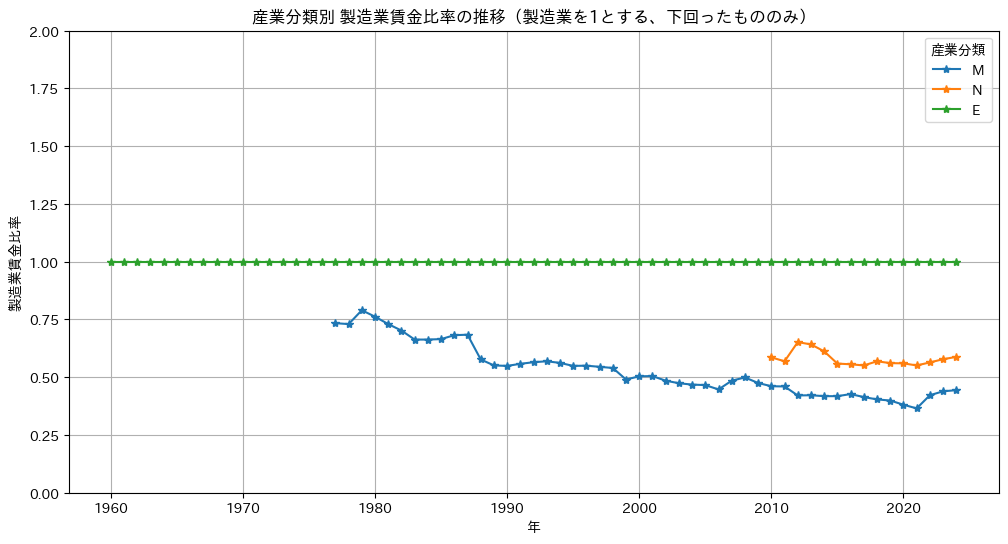

In [24]:
plt.figure(figsize=(12, 6))

cat_lower.append("E")

for industry in cat_lower:
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

産業分類は
- M：宿泊業、飲食サービス業
- N：生活関連サービス業、娯楽業

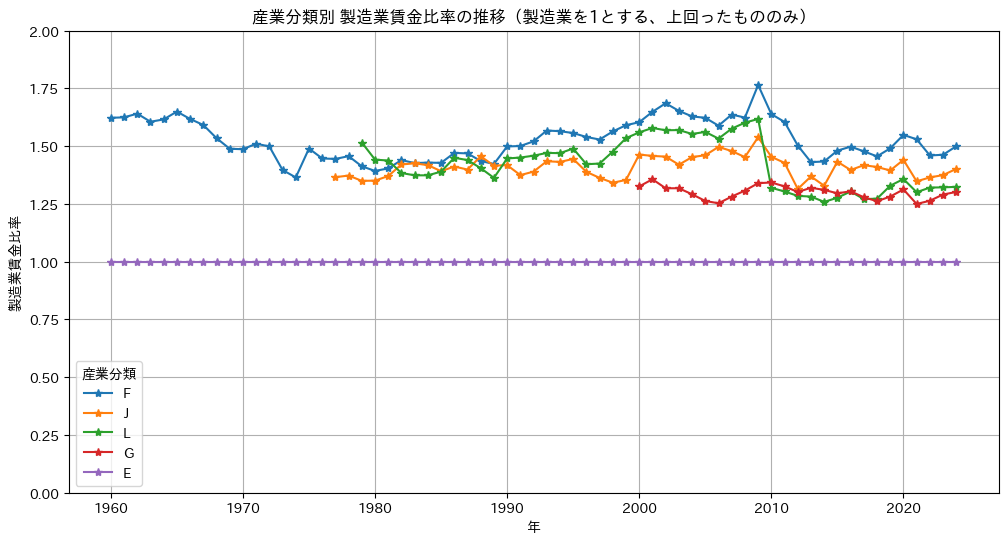

In [25]:
plt.figure(figsize=(12, 6))

cat_upper.append("E")

for industry in cat_upper:
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする、上回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

産業分類は
- F：電気・ガス・熱供給・水道業
- J：金融業、保険業
- L：学術研究、専門・技術サービス業
- G：情報通信業

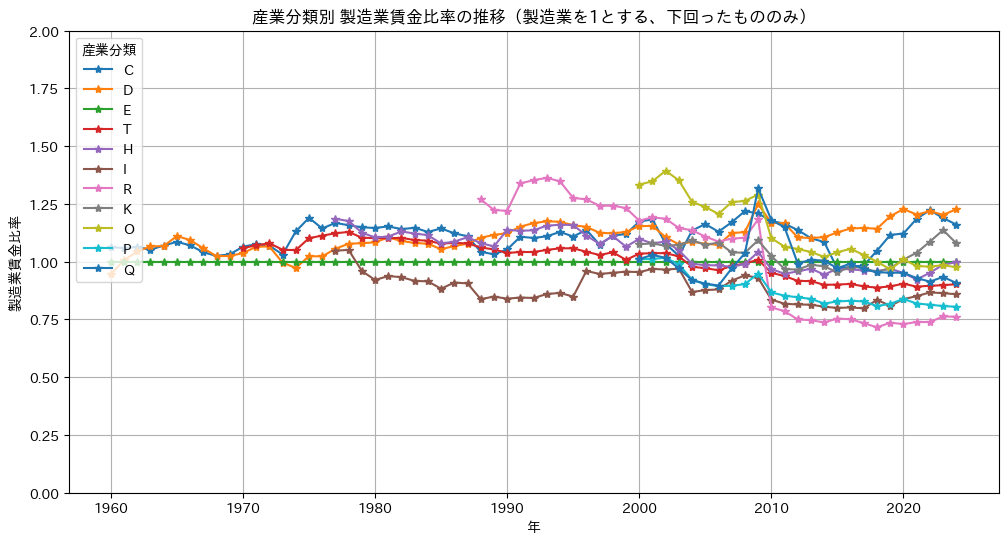

In [26]:
plt.figure(figsize=(12, 6))


for industry in cat_cross:
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

企業規模によっても、賃金は異なる。
特に日本は[全企業数の99.7%が中小企業](https://www.smrj.go.jp/recruit/environment.html)と言われており、データはロングテールになっていることを考慮すべきだと考える。
大企業と中小企業を分けて考えるべきではないか。

#### 大企業と中小企業を考慮した賃金比

[中小企業・小規模企業者の定義](https://www.chusho.meti.go.jp/soshiki/teigi.html)
- データの区別が細かくないため、今回は100人未満を中小企業、100人以上を大企業とする

In [44]:
wages = all_data[["年","月","産業分類", "規模", "就業形態", "現金給与総額"]]
wages.head()

,年,月,産業分類,規模,就業形態,現金給与総額
0,1960,CY,C,0,0,26250
1,1960,CY,C,4,0,28786
2,1960,CY,C,5,0,22422
3,1960,CY,C,7,0,18826
4,1960,CY,D,0,0,21213


In [45]:
wages["規模"].unique()

array(['0', '4', '5', '7', '9', 'T'], dtype=object)

In [46]:
# 規模によりデータを分割する
# 4,5を大企業、それ以外を中小企業とする
companies_l = wages[wages["規模"].isin(["4", "5"])]
companies_sm = wages[~wages["規模"].isin(["4", "5", "0", "T"])]

In [47]:
companies_l.head()

,年,月,産業分類,規模,就業形態,現金給与総額
1,1960,CY,C,4,0,28786
2,1960,CY,C,5,0,22422
5,1960,CY,D,4,0,24597
6,1960,CY,D,5,0,20781
9,1960,CY,E,4,0,28690


In [48]:
companies_sm.head()

,年,月,産業分類,規模,就業形態,現金給与総額
3,1960,CY,C,7,0,18826
7,1960,CY,D,7,0,19142
11,1960,CY,E,7,0,16897
15,1960,CY,E12,7,0,14624
19,1960,CY,E13,7,0,15848


In [49]:
# 月 = CY のみのデータを抽出
companies_l = companies_l[companies_l["月"] == "CY"]
companies_sm = companies_sm[companies_sm["月"] == "CY"]

In [50]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
companies_l["産業分類"] = companies_l["産業分類"].str.slice(0,1)
companies_l["産業分類"].unique()

companies_sm["産業分類"] = companies_sm["産業分類"].str.slice(0,1)
companies_sm["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'G', 'H', 'I', 'J', 'O', 'P', 'Q', 'K',
       'L', 'M', 'N', 'R'], dtype=object)

In [51]:
# 数値列を数値型に変換
companies_l["現金給与総額"] = pd.to_numeric(companies_l["現金給与総額"], errors='coerce')
companies_l["規模"] = pd.to_numeric(companies_l["規模"], errors='coerce')

companies_sm["現金給与総額"] = pd.to_numeric(companies_sm["現金給与総額"], errors='coerce')
companies_sm["規模"] = pd.to_numeric(companies_sm["規模"], errors='coerce')

# 規模ごとに分かれているデータを、それぞれ平均して統一
companies_l = companies_l.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
companies_l.head()

companies_sm = companies_sm.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
companies_sm.head()

,年,月,産業分類,就業形態,規模,現金給与総額
0,1960,CY,C,0,7.0,18826.0
1,1960,CY,D,0,7.0,19142.0
2,1960,CY,E,0,7.0,17974.9
3,1960,CY,F,0,7.0,33641.0
4,1961,CY,C,0,7.0,20832.0


In [52]:
# 就業形態が0（全形態）のみを抽出
companies_l = companies_l[companies_l["就業形態"] == 0]
companies_sm = companies_sm[companies_sm["就業形態"] == 0]

# 不要な列をドロップ
companies_l = companies_l.drop(columns=["月","規模","就業形態"])
companies_sm = companies_sm.drop(columns=["月","規模","就業形態"])

In [53]:
# その年の製造業に対する賃金比率を計算、小数点第3位まで
companies_l["製造業賃金比率"] = companies_l.apply(lambda row: round(row["現金給与総額"] / companies_l[(companies_l["年"] == row["年"]) & (companies_l["産業分類"] == "E")]["現金給与総額"].values[0], 3), axis=1)
companies_l.head()

companies_sm["製造業賃金比率"] = companies_sm.apply(lambda row: round(row["現金給与総額"] / companies_sm[(companies_sm["年"] == row["年"]) & (companies_sm["産業分類"] == "E")]["現金給与総額"].values[0], 3), axis=1)
companies_sm.head()

,年,産業分類,現金給与総額,製造業賃金比率
0,1960,C,18826.0,1.047
1,1960,D,19142.0,1.065
2,1960,E,17974.9,1.000
3,1960,F,33641.0,1.872
4,1961,C,20832.0,1.045


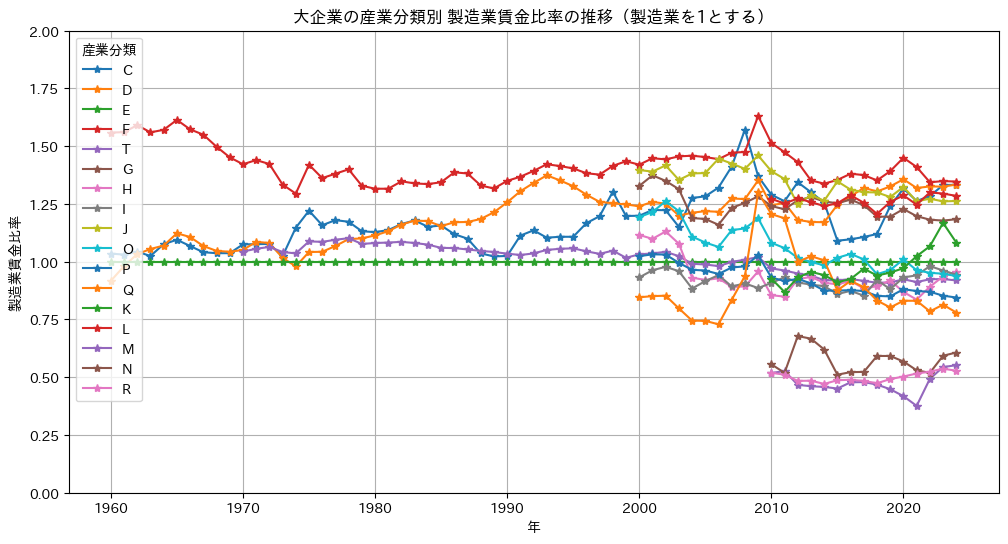

In [54]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in companies_l["産業分類"].unique():
    industry_data = companies_l[companies_l["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("大企業の産業分類別 製造業賃金比率の推移（製造業を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

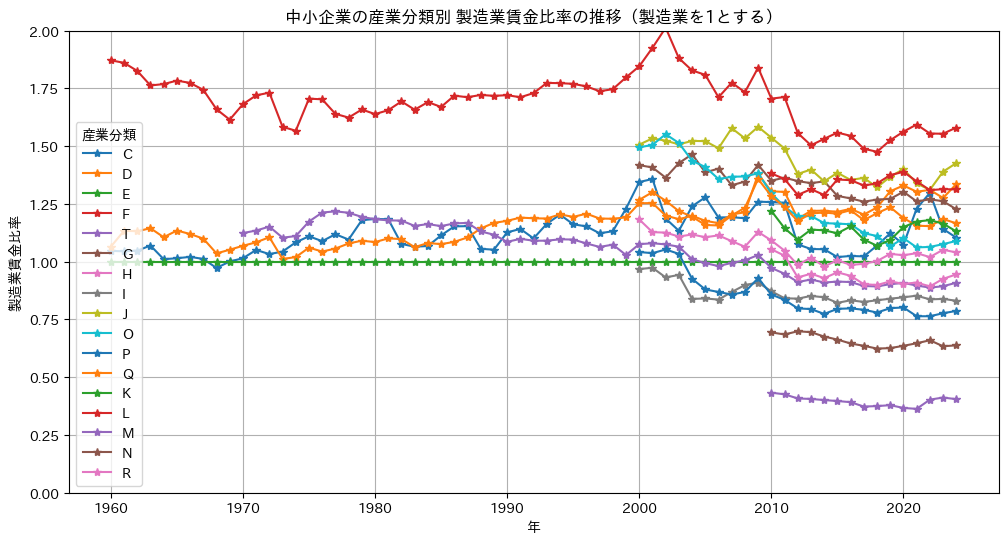

In [55]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in companies_sm["産業分類"].unique():
    industry_data = companies_sm[companies_sm["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("中小企業の産業分類別 製造業賃金比率の推移（製造業を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

- F：電気・ガス・熱供給・水道業　は常に高い（特に中小企業において）

### 可処分所得

「現金給与総額」はボーナスや残業代も含むので、「きまって支給する給与」を使用する

In [86]:
actual_wages = all_data[["年","月","産業分類", "規模", "就業形態", "きまって支給する給与"]]
actual_wages.head()

,年,月,産業分類,規模,就業形態,きまって支給する給与
0,1960,CY,C,0,0,22547.0
1,1960,CY,C,4,0,24682.0
2,1960,CY,C,5,0,19121.0
3,1960,CY,C,7,0,16814.0
4,1960,CY,D,0,0,17952.0


In [87]:
# 月 = CY のみのデータを抽出
actual_wages = actual_wages[actual_wages["月"] == "CY"]

In [88]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
actual_wages["産業分類"] = actual_wages["産業分類"].str.slice(0,1)
actual_wages["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [89]:
# 規模によりデータを分割する
# 4,5を大企業、それ以外を中小企業とする
actual_wages_l = actual_wages[actual_wages["規模"].isin(["4", "5"])]
actual_wages_sm = actual_wages[~actual_wages["規模"].isin(["4", "5", "0", "T"])]

In [90]:
# 数値列を数値型に変換
actual_wages_l.loc[:, "きまって支給する給与"] = pd.to_numeric(actual_wages_l["きまって支給する給与"], errors='coerce')

actual_wages_sm.loc[:, "きまって支給する給与"] = pd.to_numeric(actual_wages_sm["きまって支給する給与"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
actual_wages_l = actual_wages_l.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
actual_wages_l.head()

actual_wages_sm = actual_wages_sm.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
actual_wages_sm.head()

,年,月,産業分類,就業形態,きまって支給する給与
0,1960,CY,C,0,16814.0
1,1960,CY,D,0,16821.0
2,1960,CY,E,0,15787.5
3,1960,CY,F,0,25643.0
4,1961,CY,C,0,18160.0


In [91]:
# 就業形態が0（全形態）のみを抽出
actual_wages_l = actual_wages_l[actual_wages_l["就業形態"] == 0]
actual_wages_sm = actual_wages_sm[actual_wages_sm["就業形態"] == 0]
    
# 不要な列をドロップ
actual_wages_l = actual_wages_l.drop(columns=["月","就業形態"])
actual_wages_sm = actual_wages_sm.drop(columns=["月","就業形態"])

In [92]:
actual_wages_l.head()

,年,産業分類,きまって支給する給与
0,1960,C,21901.5
1,1960,D,18802.0
2,1960,E,20000.5
3,1960,F,29204.5
4,1961,C,23302.0


非消費支出を計算するのは面倒…。

単純に、
（非消費支出）=（きまって支給する給与） - （消費支出）/ 12
とする。

※毎月勤労統計調査の給与は、月給。

In [100]:
kakei_data = pd.read_csv('./data/kakei/kakei-data_solo_cleaned.csv', encoding='utf_8_sig', low_memory=False)
kakei_data.head()

,年,消費支出
0,2007,2298536
1,2008,2343049
2,2009,2221595
3,2010,2183543
4,2011,2188517


In [101]:
# 消費支出の値は年額なので、月額に変換（小数点以下四捨五入）
kakei_data["消費支出"] = round(kakei_data["消費支出"] / 12)
kakei_data.head()

,年,消費支出
0,2007,191545.0
1,2008,195254.0
2,2009,185133.0
3,2010,181962.0
4,2011,182376.0


計算できるのは2007年～2024年まで。

In [102]:
# actual_wages_l と actual_wages_sm を、2007年以降のデータのみを抽出
actual_wages_l = actual_wages_l[actual_wages_l["年"] >= 2007]
actual_wages_sm = actual_wages_sm[actual_wages_sm["年"] >= 2007]

In [103]:
# actual_wages_l と kakei_data を年で結合
merged_l = pd.merge(actual_wages_l, kakei_data, on="年", how="inner")
merged_l.head()

,年,産業分類,きまって支給する給与,消費支出
0,2007,C,439345.0000,191545.0
1,2007,D,439153.0000,191545.0
2,2007,E,340187.6875,191545.0
3,2007,F,486766.5000,191545.0
4,2007,G,416375.5000,191545.0


### 1995年（30年前）を基準とした雇用指数

In [29]:
all_employees = all_data[["年","月","産業分類", "規模", "就業形態", "現金給与総額","本月末労働者数","パートタイム労働者数"]]
all_employees.head()

,年,月,産業分類,規模,就業形態,現金給与総額,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,0,26250,NaN,NaN
1,1960,CY,C,4,0,28786,NaN,NaN
2,1960,CY,C,5,0,22422,NaN,NaN
3,1960,CY,C,7,0,18826,NaN,NaN
4,1960,CY,D,0,0,21213,NaN,NaN


In [30]:
# 月 = CY のみのデータを抽出
all_employees = all_employees[all_employees["月"] == "CY"]

In [31]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
all_employees["産業分類"] = all_employees["産業分類"].str.slice(0,1)
all_employees["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [32]:
# 数値列を数値型に変換
all_employees["現金給与総額"] = pd.to_numeric(all_employees["現金給与総額"], errors='coerce')
all_employees["本月末労働者数"] = pd.to_numeric(all_employees["本月末労働者数"], errors='coerce')
all_employees["パートタイム労働者数"] = pd.to_numeric(all_employees["パートタイム労働者数"], errors='coerce')
all_employees["規模"] = pd.to_numeric(all_employees["規模"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
all_employees = all_employees.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
all_employees.head()

,年,月,産業分類,就業形態,規模,現金給与総額,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,4.0,24071.00,NaN,NaN
1,1960,CY,D,0,4.0,21433.25,NaN,NaN
2,1960,CY,E,0,4.0,22637.30,NaN,NaN
3,1960,CY,F,0,4.0,36734.00,NaN,NaN
4,1961,CY,C,0,4.0,26290.75,NaN,NaN


In [33]:
# 就業形態が0（全形態）のみを抽出
all_employees = all_employees[all_employees["就業形態"] == 0]

# 不要な列をドロップ
all_employees = all_employees.drop(columns=["月","規模","就業形態"])

In [34]:
# 本月末労働者数とパートタイム労働者数を、小数点以下切り上げ
all_employees["本月末労働者数"] = np.ceil(all_employees["本月末労働者数"])
all_employees["パートタイム労働者数"] = np.ceil(all_employees["パートタイム労働者数"])

In [35]:
# 1995年以降のデータを抽出
all_employees = all_employees[all_employees["年"] >= 1995]

In [36]:
# 1995年の本月末労働者数を基準に、各年の労働者数を各産業ごとに指数化（小数点第3位まで）
all_employees = all_employees.merge(
    all_employees[all_employees["年"] == 1995][["産業分類", "本月末労働者数"]].rename(columns={"本月末労働者数": "基準労働者数"}),
    on="産業分類",
    how="left"
)
all_employees["労働者数指数"] = round(all_employees["本月末労働者数"] / all_employees["基準労働者数"], 3)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0


In [44]:
# 1995年の現金給与総額を基準に、各年の賃金を各産業ごとに指数化（小数点第3位まで）
all_employees = all_employees.merge(
    all_employees[all_employees["年"] == 1995][["産業分類", "現金給与総額"]].rename(columns={"現金給与総額": "基準現金給与総額"}),
    on="産業分類",
    how="left"
)
all_employees["現金給与総額指数"] = round(all_employees["現金給与総額"] / all_employees["基準現金給与総額"], 3)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数,基準現金給与総額,現金給与総額指数
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0,411388.500000,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0,429623.083333,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0,370957.833333,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0,577502.375000,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0,429780.000000,1.0


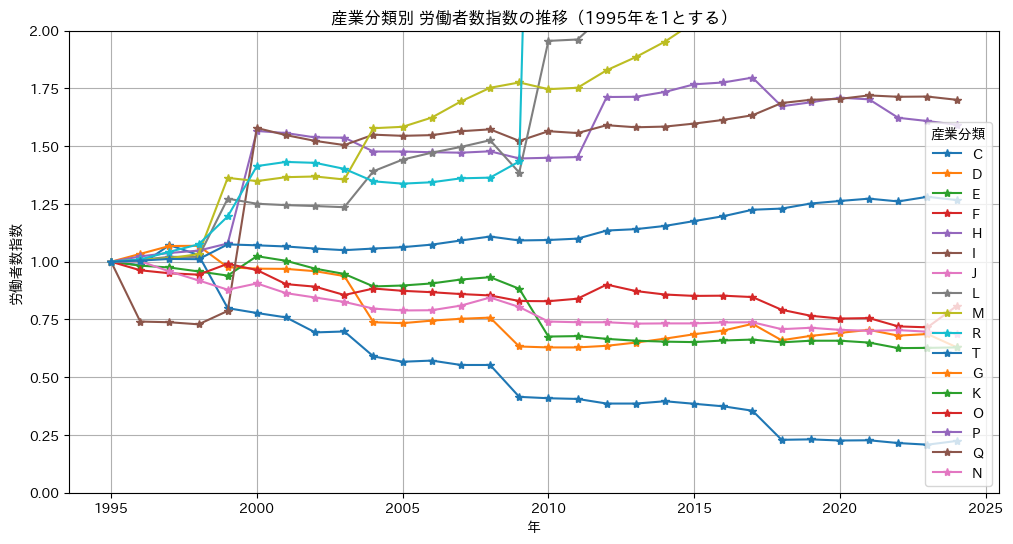

In [47]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["労働者数指数"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("労働者数指数")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 労働者数指数の推移（1995年を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

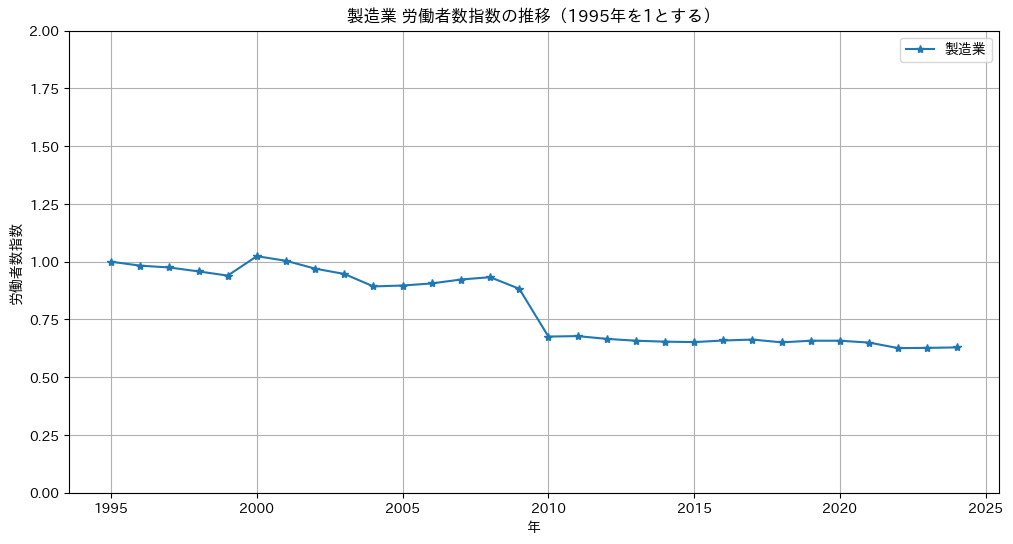

In [45]:
# 産業分類E（製造業）のみを抽出
e_employees = all_employees[all_employees["産業分類"] == "E"]

# グラフ化
plt.figure(figsize=(12, 6))
plt.plot(e_employees["年"], e_employees["労働者数指数"], marker='*', label="製造業")
plt.xlabel("年")
plt.ylabel("労働者数指数")
plt.ylim(0.0, 2.0)
plt.title("製造業 労働者数指数の推移（1995年を1とする）")
plt.legend()
plt.grid(True)
plt.show()

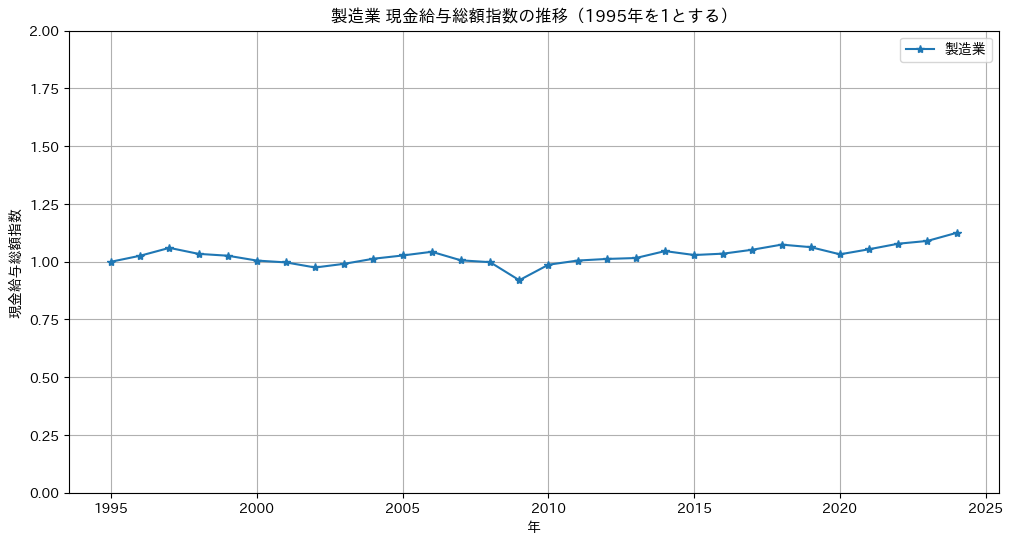

In [46]:
# 産業分類E（製造業）のみを抽出
e_employees = all_employees[all_employees["産業分類"] == "E"]

# グラフ化
plt.figure(figsize=(12, 6))
plt.plot(e_employees["年"], e_employees["現金給与総額指数"], marker='*', label="製造業")
plt.xlabel("年")
plt.ylabel("現金給与総額指数")
plt.ylim(0.0, 2.0)
plt.title("製造業 現金給与総額指数の推移（1995年を1とする）")
plt.legend()
plt.grid(True)
plt.show()

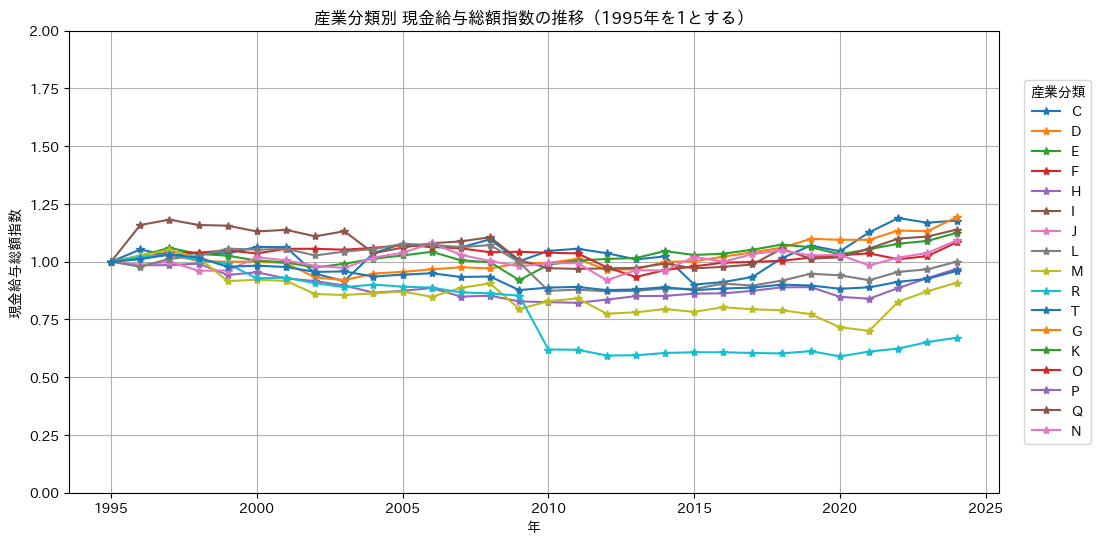

In [50]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

In [51]:
# 現金給与総額指数の、対製造業を計算
all_employees["現金給与総額指数対製造業"] = all_employees.apply(lambda row: round(row["現金給与総額指数"] / all_employees[(all_employees["年"] == row["年"]) & (all_employees["産業分類"] == "E")]["現金給与総額指数"].values[0], 3), axis=1)
all_employees.head()

,年,産業分類,現金給与総額,本月末労働者数,パートタイム労働者数,基準労働者数,労働者数指数,基準現金給与総額,現金給与総額指数,現金給与総額指数対製造業
0,1995,C,411388.500000,26535.0,710.0,26535.0,1.0,411388.500000,1.0,1.0
1,1995,D,429623.083333,1259773.0,41194.0,1259773.0,1.0,429623.083333,1.0,1.0
2,1995,E,370957.833333,681414.0,59752.0,681414.0,1.0,370957.833333,1.0,1.0
3,1995,F,577502.375000,153320.0,2238.0,153320.0,1.0,577502.375000,1.0,1.0
4,1995,H,429780.000000,621037.0,31483.0,621037.0,1.0,429780.000000,1.0,1.0


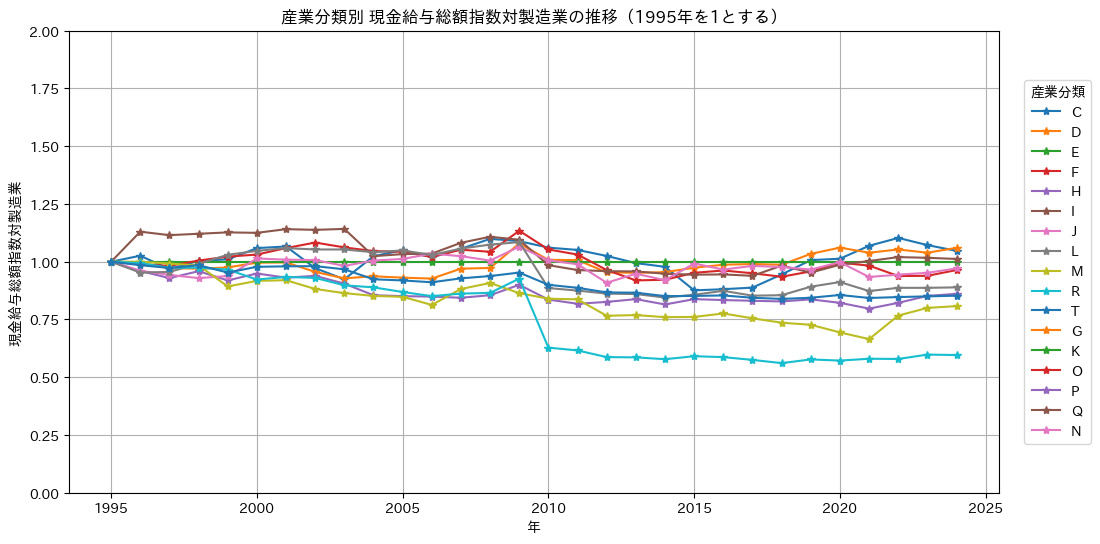

In [52]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_employees["産業分類"].unique():
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

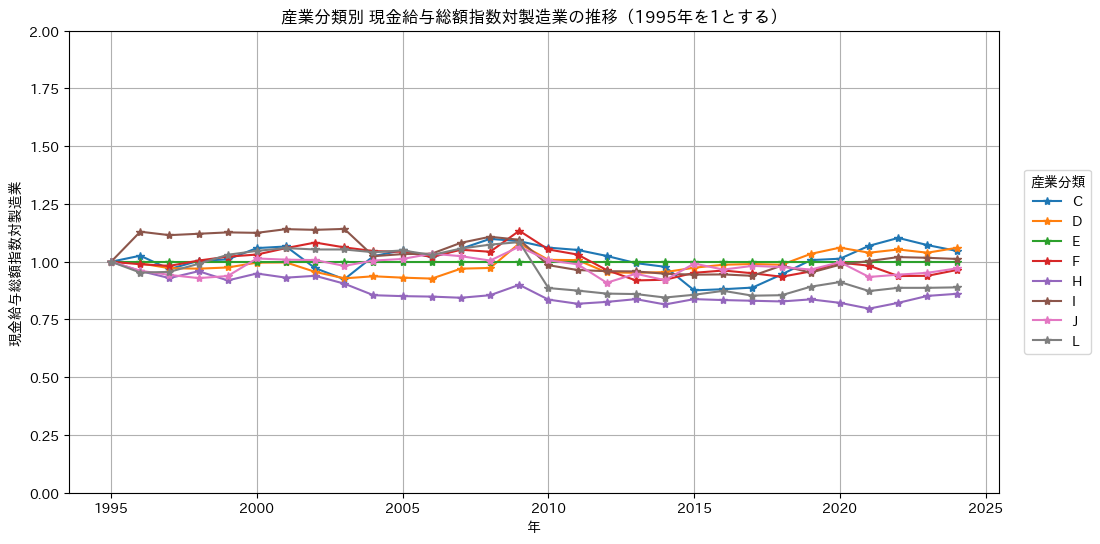

In [54]:
# 多すぎるので、産業分類カテゴリの半分ずつプロット
industries = all_employees["産業分類"].unique()
mid_index = len(industries) // 2
plt.figure(figsize=(12, 6))
for industry in industries[:mid_index]:
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

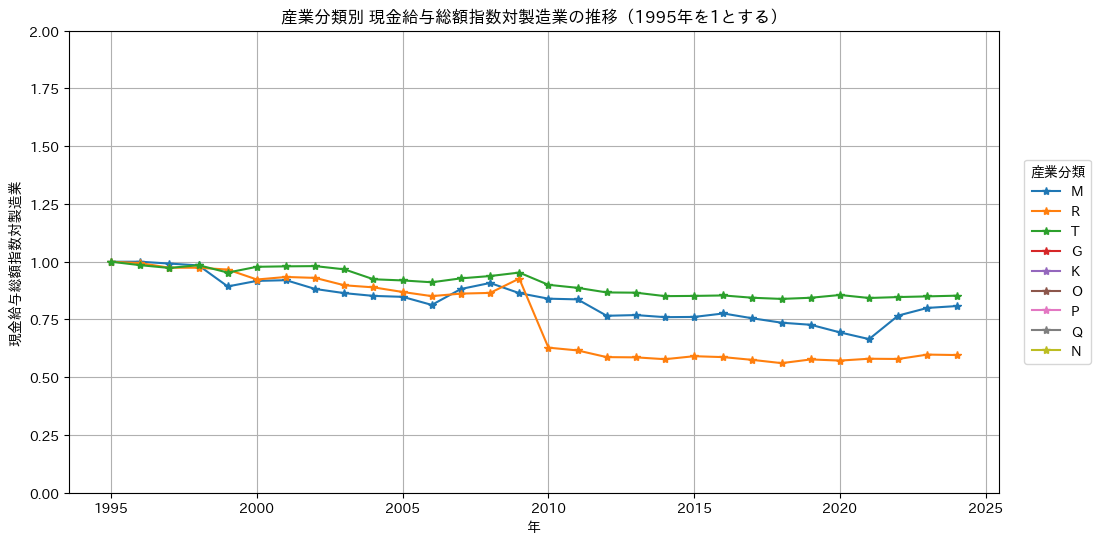

In [55]:
# もう半分をプロット
plt.figure(figsize=(12, 6))
for industry in industries[mid_index:]:
    industry_data = all_employees[all_employees["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["現金給与総額指数対製造業"], marker='*', label=industry)
plt.xlabel("年")
plt.ylabel("現金給与総額指数対製造業")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 現金給与総額指数対製造業の推移（1995年を1とする）")
plt.legend(title="産業分類", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)
plt.show()

### 雇用者数の割合

In [54]:
# 各産業分類ごとに、その年の全労働者数に対する労働者数割合を計算、小数点第3位まで
total_employees_per_year = all_data.groupby("年")["本月末労働者数"].sum().reset_index().rename(columns={"本月末労働者数": "全労働者数"})
all_employees = pd.merge(all_data, total_employees_per_year, on="年", how="left")
all_employees["労働者数割合"] = round((all_employees["本月末労働者数"] / all_employees["全労働者数"]) * 100, 3)
all_employees.head()

,年,産業分類,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数,全労働者数,労働者数割合
0,1960,C,24071.00,20791.00,NaN,NaN,3703.0,192.8500,172.6500,20.200,23.175,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,1960,D,21433.25,18094.25,NaN,NaN,3261.0,211.3000,186.2000,25.100,24.050,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,1960,E,22637.30,18694.90,NaN,NaN,4106.8,210.5675,182.1225,28.445,24.145,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,1960,F,36734.00,27890.25,NaN,NaN,8669.0,183.1750,168.4250,14.750,23.950,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1961,C,26290.75,22150.75,NaN,NaN,4716.0,191.9000,170.6250,21.275,22.850,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [55]:
# 1995年以降のデータを抽出
all_employees = all_employees[all_employees["年"] >= 1995]
all_employees.head()

,年,産業分類,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数,全労働者数,労働者数割合
235,1995,C,411388.500000,322190.166667,288915.000000,33275.166667,89198.333333,179.600000,163.233333,16.366667,21.666667,2.656233e+04,312.833333,340.166667,2.653500e+04,709.166667,5.360882e+06,0.495
236,1995,D,429623.083333,338670.583333,317004.083333,21666.500000,90952.500000,172.666667,160.866667,11.800000,21.058333,1.260099e+06,25553.083333,25878.833333,1.259773e+06,41193.083333,5.360882e+06,23.499
237,1995,E,370957.833333,288635.666667,260068.180556,28567.486111,82322.166667,167.120833,154.101389,13.019444,20.275000,6.825825e+05,8009.555556,9178.472222,6.814136e+05,59751.791667,5.360882e+06,12.711
238,1995,F,577502.375000,415488.625000,371187.125000,44301.500000,162013.750000,158.400000,145.912500,12.487500,19.287500,1.533008e+05,1770.125000,1751.250000,1.533196e+05,2237.625000,5.360882e+06,2.860
239,1995,H,429780.000000,337585.166667,288905.166667,48680.000000,92194.833333,183.450000,160.100000,23.350000,21.033333,6.208583e+05,9079.666667,8901.666667,6.210363e+05,31482.333333,5.360882e+06,11.585


In [56]:
# 2024年時点での各産業分類の労働者数割合を取得
employees_2024 = all_employees[all_employees["年"] == 2024].groupby("産業分類")["労働者数割合"].mean().reset_index()
print("2024年の産業分類別労働者数割合:")
print(employees_2024.sort_values("労働者数割合", ascending=False))

# 1%未満の産業分類を"その他"に分類
minor_industries = employees_2024[employees_2024["労働者数割合"] < 1.0]["産業分類"].tolist()
print("\n1%未満の産業分類（その他に分類）:", minor_industries)

# 新しい産業分類列を作成
def reclassify_industry(industry):
    if industry == "E":
        return "E"  # 製造業は単独
    elif industry in minor_industries:
        return "その他"
    else:
        return industry

all_employees["産業分類_新"] = all_employees["産業分類"].apply(reclassify_industry)
print("\n新しい産業分類:")
print(all_employees["産業分類_新"].unique())

# "その他"のデータを集約
all_employees_grouped = all_employees.groupby(["年", "産業分類_新"]).agg({
    "本月末労働者数": "sum",
    "全労働者数": "first"  # 全労働者数は同じ年であれば同じ値
}).reset_index()

2024年の産業分類別労働者数割合:
   産業分類  労働者数割合
13    P  23.777
6     I  13.040
15    R  10.248
12    O   9.493
10    M   9.186
5     H   6.779
1     D   5.437
4     G   4.699
11    N   4.019
9     L   3.657
2     E   2.939
8     K   2.512
7     J   2.388
14    Q   0.936
3     F   0.849
0     C   0.041

1%未満の産業分類（その他に分類）: ['C', 'F', 'Q']

新しい産業分類:
['その他' 'D' 'E' 'H' 'I' 'J' 'L' 'M' 'R' 'G' 'K' 'O' 'P' 'N']


In [57]:
all_employees_grouped.head()

,年,産業分類_新,本月末労働者数,全労働者数
0,1995,D,1.259773e+06,5.360882e+06
1,1995,E,6.814136e+05,5.360882e+06
2,1995,H,6.210363e+05,5.360882e+06
3,1995,I,1.118604e+06,5.360882e+06
4,1995,J,5.059300e+05,5.360882e+06


In [59]:
import matplotlib.cm as cm

C:\Users\chika\AppData\Local\Temp\ipykernel_13728\3369531845.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_colors)  # tab20は20色まで


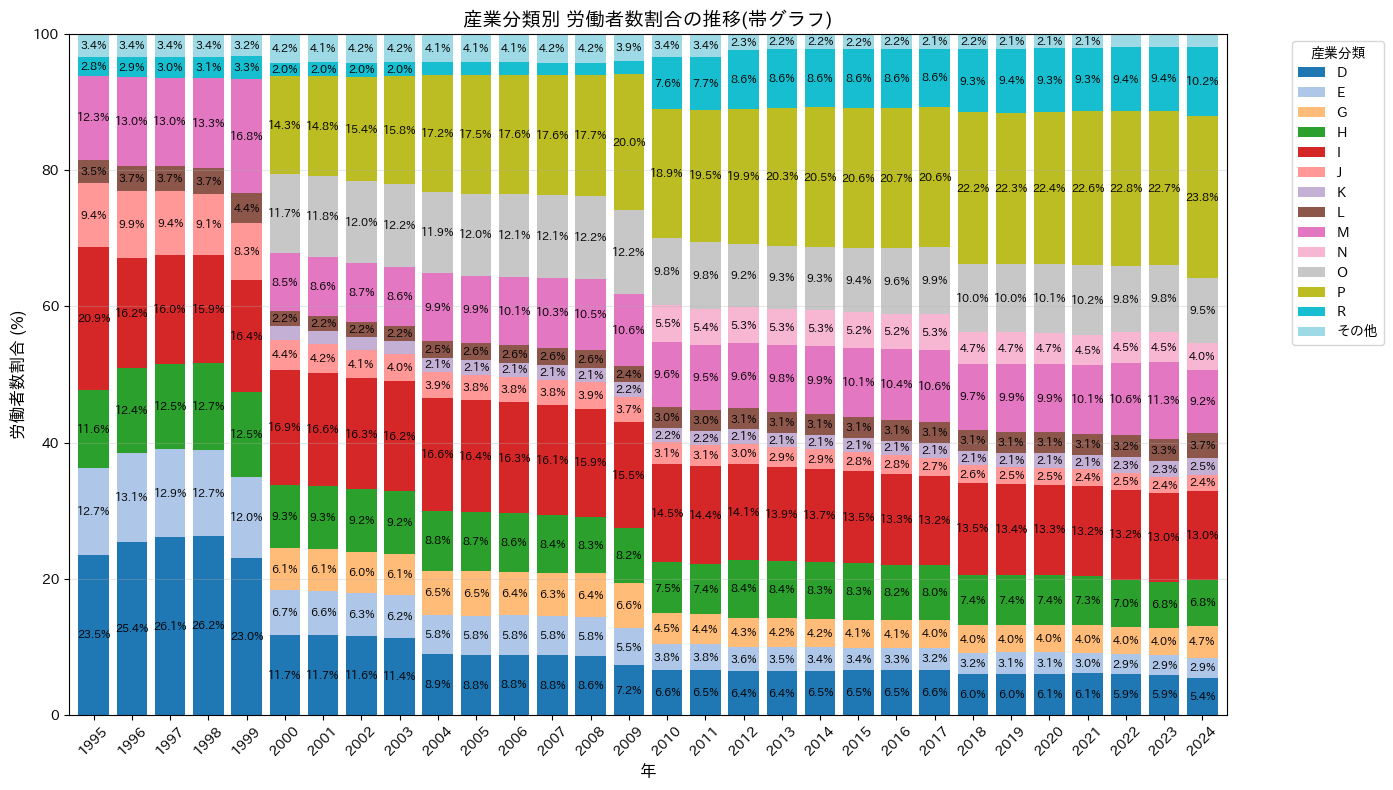

In [62]:
# 労働者数割合を再計算
all_employees_grouped["労働者数割合"] = (all_employees_grouped["本月末労働者数"] / all_employees_grouped["全労働者数"]) * 100

# ピボットテーブルを作成（年 × 産業分類_新）
pivot_data = all_employees_grouped.pivot(index="年", columns="産業分類_新", values="労働者数割合").fillna(0)

# より多くの色を使用するためのカラーマップを設定
n_colors = len(pivot_data.columns)
cmap = cm.get_cmap('tab20', n_colors)  # tab20は20色まで
colors = [cmap(i) for i in range(n_colors)]

# 帯グラフをプロット
fig, ax = plt.subplots(figsize=(14, 8))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=colors)

# 各バーに労働者数割合の値を表示
for i, year in enumerate(pivot_data.index):
    y_offset = 0
    for col in pivot_data.columns:
        value = pivot_data.loc[year, col]
        if value > 2.0:  # 2%以上の場合のみ表示
            ax.text(i, y_offset + value / 2, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=8, color='black', fontweight='bold')
        y_offset += value

ax.set_xlabel("年", fontsize=12)
ax.set_ylabel("労働者数割合 (%)", fontsize=12)
ax.set_title("産業分類別 労働者数割合の推移(帯グラフ)", fontsize=14)
ax.legend(title="産業分類", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

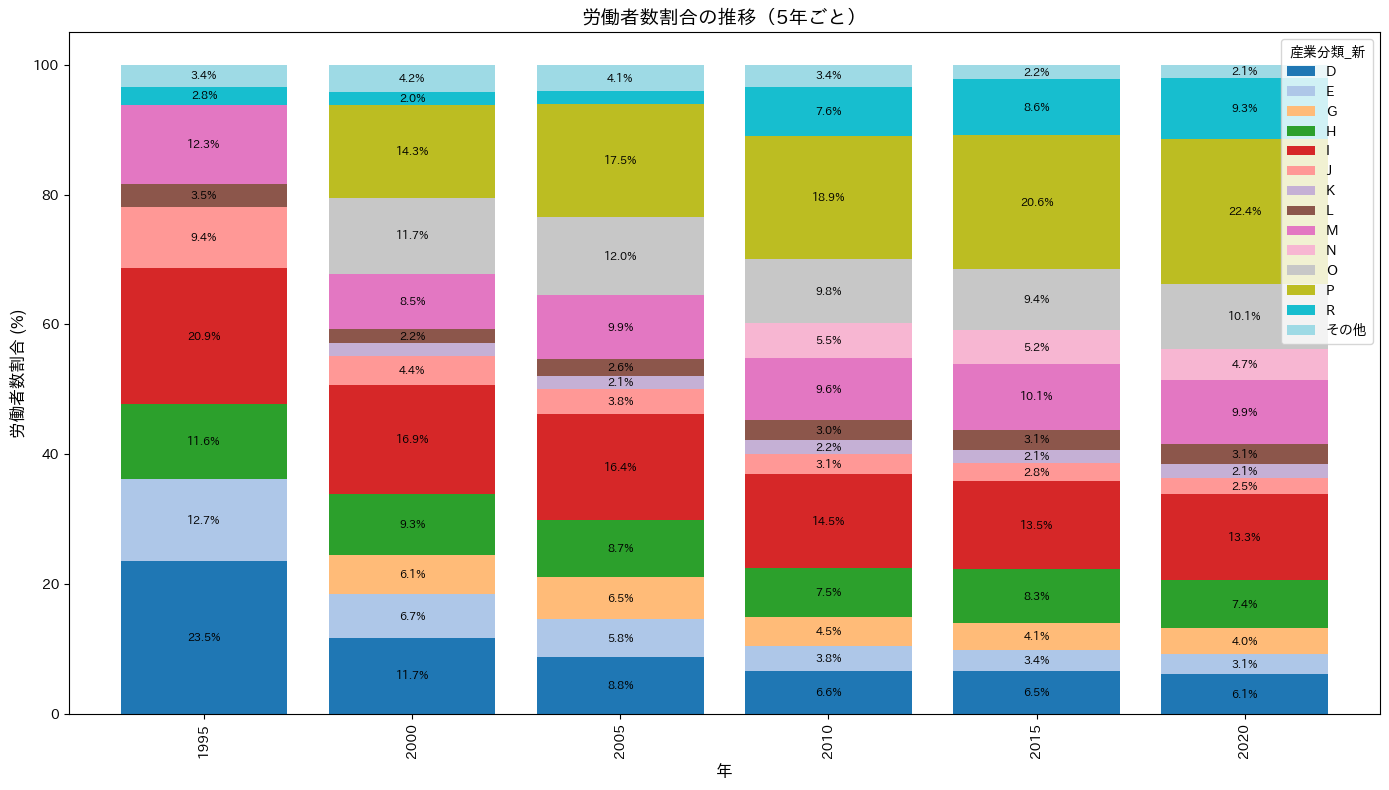

In [64]:
# 多すぎるので、5年ずつ間引いてプロット（最終年は2024年）
years_to_plot = list(range(1995, 2025, 5))
pivot_data_reduced = pivot_data.loc[years_to_plot]
# 帯グラフをプロット
fig, ax = plt.subplots(figsize=(14, 8))
pivot_data_reduced.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=colors)
# 各バーに労働者数割合の値を表示
for i, year in enumerate(pivot_data_reduced.index):
    y_offset = 0
    for col in pivot_data_reduced.columns:
        value = pivot_data_reduced.loc[year, col]
        if value > 2.0:  # 2%以上の場合のみ表示
            ax.text(i, y_offset + value / 2, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=8, color='black', fontweight='bold')
        y_offset += value
ax.set_xlabel("年", fontsize=12)
ax.set_ylabel("労働者数割合 (%)", fontsize=12)
plt.title("労働者数割合の推移（5年ごと）", fontsize=14)
plt.tight_layout()
plt.show()